In [1]:
import numpy as np
import numpy.linalg
from scipy.stats import kurtosis

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
#MLMC前半3つの描画用

N = 200000
P_var_list = np.zeros(10)
Z_var_list = np.zeros(10)
P_mean_list = np.zeros(10)
Z_mean_list = np.zeros(10)
kurtosis_list = np.zeros(10)

l_list = np.arange(1, 11)


for l in range(1, 11):
    X_list = np.random.normal(size = N)
    
    P_list = np.zeros(N) #P6, 2個目の数式のP_lをリストにしたもの
    Z_list = np.zeros(N) #P6, 2個目の数式のP_lをリストにしたもの
    X_list = np.random.normal(size = N)
    for n in range(N):
        Y_list = np.random.normal(size = 2 ** l)
        # まずはPを計算
        EVPI_list = np.zeros(2 ** l)
        E_f1 = np.zeros(2 ** l) #このままで良い
        E_f2 = np.zeros(2 ** l)

        for m in range(2 ** l):
            f1 = 0.
            f2 = X_list[n] + Y_list[m]
            EVPI_list[m] = max([f1, f2])
            E_f2[m] = f2
            
        P_l = np.mean(EVPI_list) - max([0., np.mean(E_f2)])
        P_list[n] = P_l
        
        #次にZを計算
        f_da1 = np.zeros(2 ** (l - 1)) #ここはいじらなくてもいい
        f_da2 = np.zeros(2 ** (l - 1))
        f_db1 = np.zeros(2 ** (l - 1)) #ここはいじらなくてもいい
        f_db2 = np.zeros(2 ** (l - 1))
        
        for m in range(2 ** (l - 1)):
            f_da2[m] = X_list[n] + Y_list[m]
            f_db2[m] = X_list[n] + Y_list[m + 2 ** (l - 1)]
        
        f_da2_mean = np.mean(f_da2)
        f_db2_mean = np.mean(f_db2)
        Z_l = (max([0., f_da2_mean]) + max([0., f_db2_mean]) - max([0., f_da2_mean + f_db2_mean])) / 2
        Z_list[n] = Z_l
    
    P_var_list[l - 1] = np.log2(np.var(P_list))
    Z_var_list[l - 1] = np.log2(np.var(Z_list))
    P_mean_list[l - 1] = np.log2(np.abs(np.mean(P_list)))
    Z_mean_list[l - 1] = np.log2(np.abs(np.mean(Z_list)))
    kurtosis_list[l - 1] = kurtosis(Z_list)

処理時間はざっと14分強

In [3]:
X = np.array([[i, 1] for i in l_list])
Y = np.reshape(Z_var_list, (10, 1))    # 目的変数（Numpyの配列）

beta = -np.linalg.lstsq(X, Y)[0][0][0]
print('beta = ', beta)

beta =  1.4330576964697208


In [4]:
X = np.array([[i, 1] for i in l_list])
Y = np.reshape(Z_mean_list, (10, 1))    # 目的変数（Numpyの配列）

alpha = -np.linalg.lstsq(X, Y)[0][0][0]
print('alpha = ', alpha)

alpha =  0.962548925318759


In [5]:
def mlmc_l(l, N): 
    #lはレベル、Nは試行回数
    #sum(Zl)とsum(Zl^2)のタプルを出力する
    X_list = np.random.normal(size = N)
    Z_list = np.zeros(N) #P6, 2個目の数式のP_lをリストにしたもの
    if l == 0:
        return (0, 0)
    else:
        for n in range(N):
            Y_list = np.random.normal(size = 2 ** l)
            
            #Zを計算
            f_da1 = np.zeros(2 ** (l - 1)) #ここはいじらなくてもいい
            f_da2 = np.zeros(2 ** (l - 1))
            f_db1 = np.zeros(2 ** (l - 1)) #ここはいじらなくてもいい
            f_db2 = np.zeros(2 ** (l - 1))

            for m in range(2 ** (l - 1)):
                f_da2[m] = X_list[n] + Y_list[m]
                f_db2[m] = X_list[n] + Y_list[m + 2 ** (l - 1)]

            f_da2_mean = np.mean(f_da2)
            f_db2_mean = np.mean(f_db2)
            Z_l = (max([0., f_da2_mean]) + max([0., f_db2_mean]) - max([0., f_da2_mean + f_db2_mean])) / 2
            Z_list[n] = Z_l
        return (np.sum(Z_list), np.sum(Z_list ** 2))

In [6]:
# Algorithm 1 : MLMC

gamma = 1.
Nl_list = []
acc_eps_list = [0.0002, 0.0005, 0.001, 0.002]

for eps in acc_eps_list:
    L = 3 #MLMCで必要な最大のレベル数。1つずつ増えていく。
    N0 = 10 #N0の初期値。1だとうまくいかないようだ。
    dNl  = N0 * np.ones(L, dtype = int) #最適化するべき試行回数の"差"
    suml = np.zeros((2, L))
    Nl = np.zeros(L, dtype = int) #試行回数のリスト。これのグラフを書くのが目的。
    while sum(dNl) > 0: # extra samples need to be evaluated
        #evaluate extra samples on each level
        for l in range(L):
            if dNl[l] > 0:
                (z, zz) = mlmc_l(l + 1, dNl[l])
                Nl[l] += dNl[l]
                suml[0][l] += z
                suml[1][l] += zz

        #conpute / update estimates for V_l, l=0,...,L
        ml = np.abs(suml[0] / Nl)
        Vl = np.where(suml[1] / Nl - ml ** 2 > 0, suml[1] / Nl - ml ** 2, 0)

        for l in range(2, L):
            ml[l] = max([ml[l], ml[l - 1] / 2 ** (alpha + 1)])
            Vl[l] = max([Vl[l], Vl[l - 1] / 2 ** (beta + 1)])

        #define optimal N_l, l=0,...,L
        Cl = np.array([2. ** (gamma * l) for l in range(L)])
        Ns = np.ceil(2 * np.sqrt(Vl / Cl) * np.sum(np.sqrt(Vl * Cl)) / (eps ** 2)).astype(int)
        dNl = np.where(Ns - Nl > 0, Ns - Nl, 0)
        if np.sum(dNl > 0.01 * Nl) == 0: # 十分に収束してきてそのレベルのみで"頭打ち"になったら、
            
            #if (almost) converged, estimate remaining error and decide whether a new level is required

            #test for weak convergence
            rem = max([np.abs(ml[L - 1 + i] * 2 ** (alpha * i)) for i in range(-2, 1)]) / (2 ** alpha - 1)

            if rem > eps / np.sqrt(2):
                #if not converged, set L := L + 1, and initialize target N_L
                L = L + 1
                Vl = np.append(Vl, Vl[L - 2] / (2 ** beta))
                Nl = np.append(Nl, 0)
                ze = np.zeros((2, 1))
                suml = np.append(suml, ze, axis=1)
                
                Cl = np.array([2. ** (gamma * l) for l in range(L)])
                Ns = np.ceil(2 * np.sqrt(Vl / Cl) * np.sum(np.sqrt(Vl * Cl)) / (eps ** 2)).astype(int)
                dNl = np.where(Ns - Nl > 0, Ns - Nl, 0)
                
    #描画のためにすべてのNl_listの数を揃えないといけない。
    if len(Nl_list) > 0:
        while len(Nl) < len(Nl_list[0]):
            Nl = np.append(Nl, 0)
    Nl_list.append(Nl)
Nl_list = np.array(Nl_list)

In [7]:
#MLMCのeps^2 * Costを求める
MLMC_cost_list = []
for i in range(len(acc_eps_list)):
    c = 0
    for l in range(len(Nl_list[i])):
        c += 2 ** (l + 1) * Nl_list[i][l]
    MLMC_cost_list.append(c * acc_eps_list[i] ** 2)
    
Nl_list = np.where(Nl_list > 1, Nl_list, np.nan)

In [37]:
acc_eps_list = [0.0002, 0.0005, 0.001, 0.002]

In [38]:
#Std MCについて
#必要なレベルはMLMCの時のものを引用し、必要な分だけNを増やすアルゴリズムを考えることにする。
def stdmc_l(l, N):
    #funcを定義する
    X_list = np.random.normal(size = N)
    P_list = np.zeros(N)
    if l == 0:
        return (0, 0)
    else:
        for n in range(N):
            Y_list = np.random.normal(size = 2 ** l)
            
            #Pを計算
            EVPI_list = np.zeros(2 ** l)
            E_f1 = np.zeros(2 ** l) #このままで良い
            E_f2 = np.zeros(2 ** l)

            for m in range(2 ** l):
                f1 = 0.
                f2 = X_list[n] + Y_list[m]
                EVPI_list[m] = max([f1, f2])
                E_f2[m] = f2

            P = np.mean(EVPI_list) - max([0., np.mean(E_f2)])
            P_list[n] = P
        return (np.sum(P_list), np.sum(P_list ** 2))
    
StdMC_cost_list = []

for i in range(len(acc_eps_list)):
    #Lを決定する
    L = len(Nl_list[0])
    while np.isnan(Nl_list[i][L - 1]):
        L -= 1
    
    dN  = 100 #最適化するべき試行回数の"差"
    s = np.array([0, 0])
    N = 0 #実際に試行した回数
    
    while dN > 0: # extra samples need to be evaluated
        #evaluate extra samples on each level
        rdN = int((dN * 1.8 + 1) // 2)
        (z, zz) = stdmc_l(L, rdN) 
        #Vlが確定値ではないので、dNではなくそれよりやや小さい回数(0.9倍)だけ試行する。四捨五入の手法は競技プログラミングの技法から。
        N += rdN
        s[0] += z
        s[1] += zz
        
        #conpute / update estimates for V
        m = np.abs(s[0] / N)
        V = max(s[1] / N - m ** 2, 0)
        
        #define optimal N
        Ns = np.ceil(2 * V / acc_eps_list[i] ** 2).astype(int)
        dN = Ns - N
                
    StdMC_cost_list.append(acc_eps_list[i] ** 2 * 2 ** L * N)

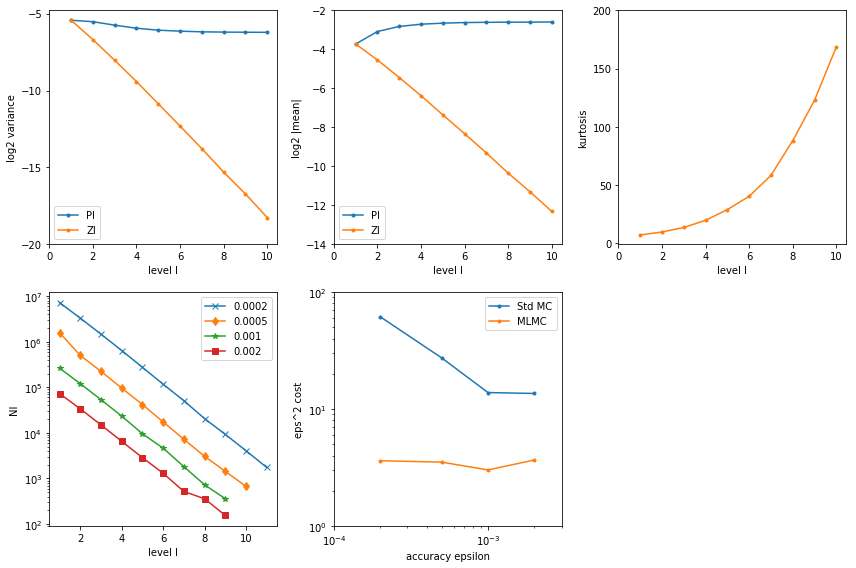

In [48]:
#描画
l_list_1 = np.arange(1, 11) #x軸として用いる
l_list_2 = np.arange(1, len(Nl_list[0]) + 1) 

fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

ax1 = fig.add_subplot(2, 3, 1)
ax1.set_xlabel("level l")
ax1.set_ylabel("log2 variance")
ax1.plot(l_list_1, P_var_list, marker='.', label="Pl")
ax1.plot(l_list_1, Z_var_list, marker='.', label="Zl")
ax1.set_xticks(np.arange(0, 12, 2))
ax1.set_yticks(np.arange(-20, 0, 5))
ax1.legend()

ax2 = fig.add_subplot(2, 3, 2)
ax2.set_xlabel("level l")
ax2.set_ylabel("log2 |mean|")
ax2.plot(l_list_1, P_mean_list, marker='.', label="Pl")
ax2.plot(l_list_1, Z_mean_list, marker='.', label="Zl")
ax2.set_xticks(np.arange(0, 12, 2))
ax2.set_yticks(np.arange(-14, 0, 2))
ax2.legend()

ax3 = fig.add_subplot(2, 3, 3)
ax3.set_xlabel("level l")
ax3.set_ylabel("kurtosis")
ax3.plot(l_list_1, kurtosis_list, marker='.', color = '#ff7f0e')
ax3.set_xticks(np.arange(0, 12, 2))
ax3.set_yticks(np.arange(0, 250, 50))

ax4 = fig.add_subplot(2, 3, 4)
ax4.set_xlabel("level l")
ax4.set_ylabel("Nl")
ax4.set_yscale('log')
ax4.plot(l_list_2, Nl_list[0], marker='x', label="0.0002")
ax4.plot(l_list_2, Nl_list[1], marker='d', label="0.0005")
ax4.plot(l_list_2, Nl_list[2], marker='*', label="0.001")
ax4.plot(l_list_2, Nl_list[3], marker='s', label="0.002")
ax4.legend()

ax5 = fig.add_subplot(2, 3, 5)
ax5.set_xlabel("accuracy epsilon")
ax5.set_ylabel("eps^2 cost")
ax5.set_xscale('log')
ax5.set_xlim(1e-4, 3 * 1e-3)
ax5.set_yscale('log')
ax5.set_ylim(1e0, 1e2)
ax5.plot(acc_eps_list, StdMC_cost_list, marker='.', label="Std MC")
ax5.plot(acc_eps_list, MLMC_cost_list, marker='.', label="MLMC")
ax5.legend()

plt.tight_layout()

plt.savefig("EVPPI_simple.png")
plt.show()